# Consolidated model

## Summary
This notebook aggregates the results from LASSO, stepwise regression, and K-TSP to a single unified network.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Scott\Envs\train_lasso\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Scott\Envs\train_lasso\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\Scott\Envs\train_lasso\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 1. Load Data
This section loads all model coefficients from LASSO and stepwise regression. For the KTSP algorithm, we load the PCC.

In [2]:
basepath = "D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/results/consolidated_network.xlsx"

### A. AUC --> MET

First, get the average coefficients out into a single dataframe.

In [3]:
sheetnames = ['met2auc_lasso', 'met2auc_1step', 'met2auc_2step', 'met2auc_3step']
met2auc_coef = [abs(pd.read_excel(basepath, sheet_name=sheet, index_col='Target')) for sheet in sheetnames]
met2auc_df = pd.concat(met2auc_coef, join='outer').groupby(level=0, axis=0).sum()
met2auc_df = met2auc_df.fillna(1)
met2auc_df.head(3)

,2-aminoadipate,3-phosphoglycerate,Alpha-glycerophosphate,4-pyridoxate,Aconitate,Adenine,Adipate,Alpha-ketoglutarate,AMP,Citrate,...,Lauroylcarnitine,Myristoylcarnitine,Palmitoylcarnitine,Stearoylcarnitine,Oleylcarnitine,Arachidonyl carnitine,Sarcosine,Beta-alanine,Anserine,Arachidonyl-carnitine
Target,,,,,,,,,,,,,,,,,,,,,
AGK-2,0.020777,0.028616,0.009860,0.007258,0.004597,0.009335,0.023477,0.010382,0.035427,0.008785,...,0.026285,0.007764,0.020508,0.016232,0.009905,0.013239,0.005940,0.003716,0.028640,0.0
Apicidin,0.050481,0.010940,0.030396,0.032251,0.021555,0.002824,0.039591,0.061708,0.078462,0.005594,...,0.041638,0.023564,0.019083,0.027988,0.037360,0.015935,0.105150,0.019954,0.027380,0.0
BIX-01294,0.024140,0.004778,0.017059,0.003333,0.025125,0.013433,0.012785,0.004452,0.039237,0.010571,...,0.008019,0.010614,0.020471,0.018057,0.026040,0.007107,0.046672,0.000850,0.042193,0.0


In [4]:
N_freq = pd.concat(met2auc_coef, join='outer').groupby(level=0, axis=0).count()
N_freq = N_freq.replace(0.0, 1.0)

Now get the correlation coefficients from KTSP.

In [5]:
met2auc_corr = pd.read_excel(basepath, sheet_name='met2auc_ktsp', index_col='Target')

If there is a KTSP correlation that intersects with the coefficient matrix, then you will take a multiplicative approach to scale the coefficients based on the correlation coefficient. 

In [6]:
for target in met2auc_corr.index:
    if target in met2auc_df.index:
        N_freq.loc[target, :] += 1
        A = met2auc_corr.loc[target].values
        B = met2auc_df.loc[target, :].values
        met2auc_df.loc[target, :] = A * B

        del A, B

In [7]:
met2auc_df = met2auc_df + N_freq
for col in met2auc_df.columns:
    met2auc_df.loc[met2auc_df[col] == 1, col] = 0
print(met2auc_df.shape)
met2auc_df.head(3)

(34, 135)


,2-aminoadipate,3-phosphoglycerate,Alpha-glycerophosphate,4-pyridoxate,Aconitate,Adenine,Adipate,Alpha-ketoglutarate,AMP,Citrate,...,Lauroylcarnitine,Myristoylcarnitine,Palmitoylcarnitine,Stearoylcarnitine,Oleylcarnitine,Arachidonyl carnitine,Sarcosine,Beta-alanine,Anserine,Arachidonyl-carnitine
Target,,,,,,,,,,,,,,,,,,,,,
AGK-2,1.020777,1.028616,1.009860,1.007258,1.004597,1.009335,1.023477,1.010382,1.035427,1.008785,...,1.026285,1.007764,1.020508,1.016232,1.009905,1.013239,1.005940,1.003716,1.028640,0.0
Apicidin,2.000649,2.000141,2.000391,2.000414,2.000277,2.000036,2.000509,2.000793,2.001008,2.000072,...,2.000535,2.000303,2.000245,2.000360,2.000480,2.000205,2.001351,2.000256,2.000352,2.0
BIX-01294,1.024140,1.004778,1.017059,1.003333,1.025125,1.013433,1.012785,1.004452,1.039237,1.010571,...,1.008019,1.010614,1.020471,1.018057,1.026040,1.007107,1.046672,1.000850,1.042193,0.0


Let's get a sense of the distribution.

In [8]:
met2auc_df = met2auc_df.reset_index()

In [9]:
met2auc_df.head(3)

,Target,2-aminoadipate,3-phosphoglycerate,Alpha-glycerophosphate,4-pyridoxate,Aconitate,Adenine,Adipate,Alpha-ketoglutarate,AMP,...,Lauroylcarnitine,Myristoylcarnitine,Palmitoylcarnitine,Stearoylcarnitine,Oleylcarnitine,Arachidonyl carnitine,Sarcosine,Beta-alanine,Anserine,Arachidonyl-carnitine
0,AGK-2,1.020777,1.028616,1.009860,1.007258,1.004597,1.009335,1.023477,1.010382,1.035427,...,1.026285,1.007764,1.020508,1.016232,1.009905,1.013239,1.005940,1.003716,1.028640,0.0
1,Apicidin,2.000649,2.000141,2.000391,2.000414,2.000277,2.000036,2.000509,2.000793,2.001008,...,2.000535,2.000303,2.000245,2.000360,2.000480,2.000205,2.001351,2.000256,2.000352,2.0
2,BIX-01294,1.024140,1.004778,1.017059,1.003333,1.025125,1.013433,1.012785,1.004452,1.039237,...,1.008019,1.010614,1.020471,1.018057,1.026040,1.007107,1.046672,1.000850,1.042193,0.0


<AxesSubplot:xlabel='Coefficient', ylabel='Count'>

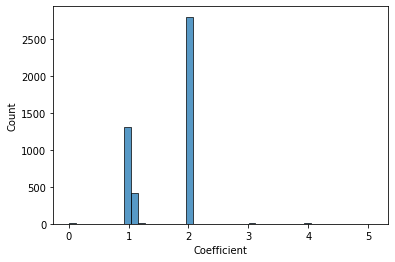

In [10]:
tmp = pd.melt(met2auc_df, 
                id_vars=['Target'], 
                var_name='Metabolite', 
                value_name='Coefficient'
)
sns.histplot(data=tmp, x='Coefficient')

In [11]:
tmp.head(3)

,Target,Metabolite,Coefficient
0,AGK-2,2-aminoadipate,1.020777
1,Apicidin,2-aminoadipate,2.000649
2,BIX-01294,2-aminoadipate,1.024140


Convert to a p-value. This is not the way to go, as there are 4 significant interactions in total, although it is interesting to note that GSK-J4 has the highest number of interactions, and the pairing with Sorbitol is a relatively stronger interaction.

In [12]:
import scipy
pvalues = scipy.stats.norm.sf(abs(tmp['Coefficient']*10))*2
print(tmp.loc[pvalues<0.05, :])
np.sum(pvalues<0.05)

             Target             Metabolite  Coefficient
0             AGK-2         2-aminoadipate     1.020777
1          Apicidin         2-aminoadipate     2.000649
2         BIX-01294         2-aminoadipate     1.024140
3     BRD-A02303741         2-aminoadipate     1.010108
4     BRD-A94377914         2-aminoadipate     2.002540
...             ...                    ...          ...
4580    Pandacostat  Arachidonyl-carnitine     2.000000
4582   Repligen 136  Arachidonyl-carnitine     2.000000
4585   Tacedinaline  Arachidonyl-carnitine     2.000000
4586   Tubastatin A  Arachidonyl-carnitine     2.000000
4589     Vorinostat  Arachidonyl-carnitine     2.000000

[4577 rows x 3 columns]


4577

Instead, lets rank the interactions using the sum of the absolute values for both metabolites and drugs.

In [13]:
met2auc_df = met2auc_df.set_index('Target')

In [14]:
drug_priority = met2auc_df.sum(axis=1).sort_values(ascending=False)
metabolite_priority = met2auc_df.sum(axis=0).sort_values(ascending=False)
metabolite_priority.head(20)

1-methylnicotinamide        67.198961
Leucine                     65.035898
N-carbamoyl-beta-alanine    63.449666
Pantothenate                63.418157
2-hydroxyglutarate          63.270904
Sorbitol                    59.906911
Xanthosine                  59.747939
Arachidonyl carnitine       59.502674
Cystathionine               59.279453
Thymidine                   59.211704
Dimethylglycine             56.295820
Valine                      56.060074
Arginine                    55.974343
Phenylalanine               55.913654
Glutamate                   55.900373
Lysine                      55.832887
SDMA/ADMA                   55.825176
Threonine                   55.822193
Malate                      55.796624
Histidine                   55.763162
dtype: float64

We'll take the bottom 10 and top 10 metabolites, and take two drugs: GSK-J4 and vorinostat.

In [15]:
drugs_to_get = ['GSK-J4', 'Vorinostat']
metabolites_to_get = pd.concat([metabolite_priority.iloc[:20]]).index.to_list()
filtered_met2auc_df = met2auc_df.loc[drugs_to_get, metabolites_to_get]
filtered_met2auc_df = filtered_met2auc_df.reset_index()
met2auc_edge = pd.melt(filtered_met2auc_df, 
                id_vars=['Target'], 
                var_name='Metabolite', 
                value_name='Coefficient'
)

In [16]:
met2auc_edge

,Target,Metabolite,Coefficient
0,GSK-J4,1-methylnicotinamide,4.017094
1,Vorinostat,1-methylnicotinamide,5.006865
2,GSK-J4,Leucine,3.849620
3,Vorinostat,Leucine,4.001025
4,GSK-J4,N-carbamoyl-beta-alanine,3.247244
5,Vorinostat,N-carbamoyl-beta-alanine,4.002217
6,GSK-J4,Pantothenate,3.024468
7,Vorinostat,Pantothenate,4.000054
8,GSK-J4,2-hydroxyglutarate,3.020924
9,Vorinostat,2-hydroxyglutarate,4.017718


In [17]:
met2auc_edge.to_csv('D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/results/Consolidated/met2auc_edge_top20.csv')

### B. MET --> GCP

In [18]:
sheetnames = ['met2gcp_lasso', 'met2gcp_1step', 'met2gcp_2step', 'met2gcp_3step']
met2gcp_coef = [abs(pd.read_excel(basepath, sheet_name=sheet, index_col='Target')) for sheet in sheetnames]
met2gcp_df = pd.concat(met2gcp_coef, join='outer').groupby(level=0, axis=0).sum()
met2gcp_df = met2gcp_df.fillna(1)

N_freq = pd.concat(met2gcp_coef, join='outer').groupby(level=0, axis=0).count()
N_freq = N_freq.replace(0.0, 1.0)

met2gcp_corr = pd.read_excel(basepath, sheet_name='met2gcp_ktsp', index_col='Target')

In [19]:
for target in met2gcp_corr.index:
    if target in met2gcp_df.index:
        N_freq.loc[target, :] += 1
        A = met2gcp_corr.loc[target].values
        B = met2gcp_df.loc[target, :].values
        met2gcp_df.loc[target, :] = A * B

        del A, B

In [20]:
met2gcp_df = met2gcp_df + N_freq
for col in met2gcp_df.columns:
    met2gcp_df.loc[met2gcp_df[col] == 1, col] = 0
print(met2gcp_df.shape)
met2gcp_df.head(3)

(20, 137)


,2-aminoadipate,3-phosphoglycerate,Alpha-glycerophosphate,4-pyridoxate,Aconitate,Adenine,Adipate,Alpha-ketoglutarate,AMP,Citrate,...,Palmitoylcarnitine,Stearoylcarnitine,Oleylcarnitine,Arachidonyl carnitine,Sarcosine,Beta-alanine,Anserine,Pipecolic Acid,Kynurenic Acid,Ribose-5-P/Ribulose-5-P
Target,,,,,,,,,,,,,,,,,,,,,
H3K14ac1,2.0000,2.0,2.000073,2.0,2.0,3.0,2.000039,2.0,2.0,2.0,...,3.0,2.0,2.0,2.0,2.0,2.000408,2.000307,3.000000,2.000000,3.000000
H3K18ac1,2.0000,3.0,3.000000,2.0,2.0,4.0,2.000000,2.0,2.0,2.0,...,4.0,2.0,3.0,2.0,2.0,2.000000,2.000000,4.000000,2.000000,4.051625
H3K23ac1,2.0004,3.0,3.000000,2.0,2.0,4.0,2.000000,2.0,2.0,2.0,...,4.0,2.0,3.0,2.0,2.0,2.000000,2.000082,4.031458,2.050341,4.000000


In [21]:
histone_priority = met2gcp_df.sum(axis=1).sort_values(ascending=False)
metabolite_priority = met2gcp_df.sum(axis=0).sort_values(ascending=False)
metabolite_priority.head(30)

Pantothenate                                                      98.377820
Acetylcholine                                                     98.262188
2-deoxycytidine                                                   98.056874
Ribose-5-P/Ribulose-5-P                                           79.330105
Pipecolic Acid                                                    79.256063
2-deoxyadenosine                                                  79.058305
Dimethylglycine                                                   78.725319
Oxalate                                                           78.440931
Palmitoylcarnitine                                                78.187151
Lactose                                                           78.145288
Adenine                                                           78.053823
Guanosine                                                         78.045054
Myristoylcarnitine                                                78.035264
Carnosine   

In [22]:
metabolites_to_get = pd.concat([metabolite_priority.iloc[:20]]).index.to_list()
histones_to_get = pd.concat([histone_priority.iloc[:10]]).index.to_list()
filtered_met2gcp_df = met2gcp_df.loc[histones_to_get, metabolites_to_get]
filtered_met2gcp_df = filtered_met2gcp_df.reset_index()
met2gcp_edge = pd.melt(filtered_met2gcp_df, 
                id_vars=['Target'], 
                var_name='Source', 
                value_name='Coefficient'
)

In [23]:
met2gcp_edge

,Target,Source,Coefficient
0,H3K23ac1,Pantothenate,5.092113
1,H3K4ac1,Pantothenate,5.000964
2,H3K36me2,Pantothenate,5.000000
3,H3K9me3,Pantothenate,5.000000
4,H3K9me2,Pantothenate,5.000000
...,...,...,...
195,H3K36me3,N-carbamoyl-beta-alanine,3.000000
196,H3K9ac1,N-carbamoyl-beta-alanine,3.000000
197,H3K4me2,N-carbamoyl-beta-alanine,3.000000
198,H3K36me1,N-carbamoyl-beta-alanine,3.000000


In [49]:
met2gcp_edge.to_csv('D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/results/Consolidated/met2gcp_edge_top20.csv')